# Sudoku

<img src="data/sudoku.jpg" width='200px'>

## Tasks
- Load an RGB image from `sudoku.jpg` or an arbitrary file from `/home/course/ImageExploration/Sudoku/` folder. 
- Convert it to grayscale.
- Try to find the border of the sudoku table and correct for the perspective until the table looks as rectangular as possible. 
- Check if the image suffers from the camera lens distortion.  
- Find the squares containing numbers and propose an algorythm to recognize the numbers?

Hint: we will need a transformation at some point https://www.youtube.com/watch?v=PtCQH93GucA

---


In [1]:
# Packages
import cv2
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from collections import Counter

FS = 20 # fontsize for images

#Load image
file_path = 'data/sudoku.jpg'
img = cv2.imread(file_path)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
size = gray_image.shape 
x_size = np.linspace(0, size[1], 100)

In [2]:
def get_slope_and_y_intercept(x1, y1, x2, y2):
    '''
    Calculate the slope and y intercept of a line which is determined by two coordinates.
    '''
    # Calculate slope
    m = (y2 - y1) / (x2 - x1)
    # Calculate y-intercept
    c = y1 - m * x1
    return m, c

# Function to find intersection point of two lines
def find_intersection(line1, line2):
    '''
    Find the intersection of two lines if those are not paralel.
    '''
    if (line1[0] - line2[0]) !=0:
        x = (line2[1] - line1[1]) / (line1[0] - line2[0])
        y = line1[0] * x + line1[1]
        return x, y
    else:
        return []
    
def generate_line(parameters, x=x_size):
    '''
    Generate a line form the slope and y intercept.
    '''
    line = []
    for p in parameters:
        line.append(p[0] * x + p[1])
    return np.array(line)

def find_crossing_points(parameters):
    # List to store crossing points
    crossing_points = []
    # Iterate through every pair of lines and find intersection points
    for i in range(len(parameters)):
        for j in range(i + 1, len(parameters)):
            cpoint = find_intersection(parameters[i], parameters[j]) # the intersection point
            # if the point does not exist --> pass
            if cpoint == []: 
                pass
            # if the crossing point is out of the picture --> pass
            elif cpoint[0]<0 or cpoint[1]<0 or cpoint[0]>size[1] or cpoint[1]>size[0]:
                pass
            # If the point exist and it is on the figure, store the coordinates
            else:
               crossing_points.append(cpoint)
    return np.array(crossing_points)

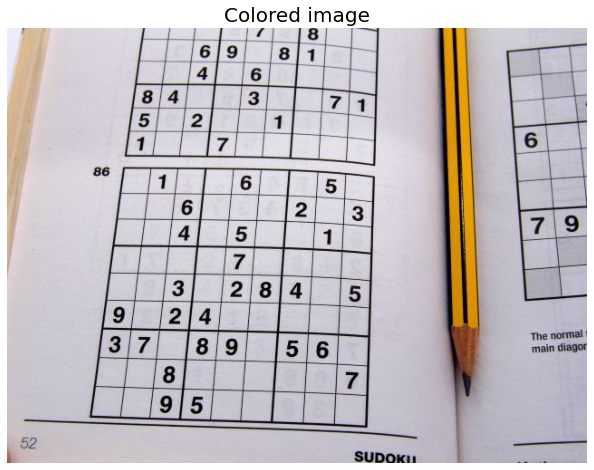

In [3]:
# The original image
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title('Colored image', fontsize=FS)
plt.show()

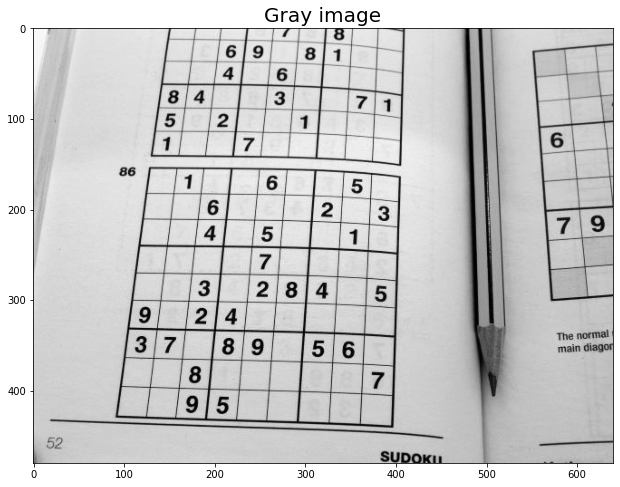

In [4]:
# The gray image
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
plt.figure(figsize=(12, 8))
plt.imshow(gray_image, cmap='gray')
plt.title('Gray image', fontsize=FS)
plt.show()

---

# Find the lattice of the sudoku grid 
- Using the [Canny](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html) edge detecion we can find the edges of the picture
- After a dilatation and an erosion we can use the [Hough Line Transform](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html), to get the distance from origin, and the angle of a line.


In [5]:
edges_1 = cv2.Canny(gray_image, 0, 66, apertureSize=3)

kernel_1 = np.ones((3,3), np.uint8)
edges_2 = cv2.dilate(edges_1, kernel_1, iterations=1)
kernel_2 = np.ones((5,5), np.uint8)
edges_3 = cv2.erode(edges_2, kernel_2, iterations=1)

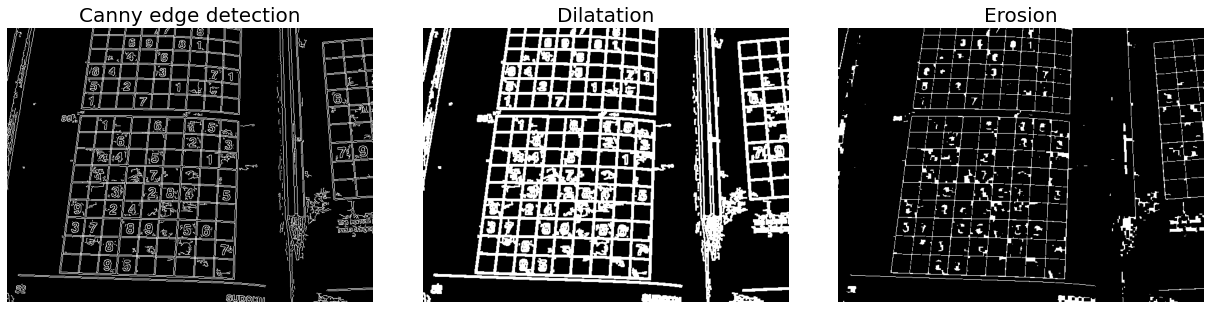

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18,12))  

axes[0].imshow(edges_1, cmap='gray')
axes[0].set_title('Canny edge detection', fontsize=FS)
axes[0].axis('off')

axes[1].imshow(edges_2, cmap='gray')
axes[1].set_title('Dilatation', fontsize=FS)
axes[1].axis('off')

axes[2].imshow(edges_3, cmap='gray')
axes[2].set_title('Erosion', fontsize=FS)
axes[2].axis('off')

plt.tight_layout(pad=5)
plt.show()

In [7]:
# Find the possible lines distace from the origin, and the angle
lines = cv2.HoughLines(edges_3, 1, np.pi/180, 150)
print(f'{lines.shape[0]} lines found.')

25 lines found.


In [8]:
# Transform the polar coordinate sytem to the Cartesian coordinate system
params = []
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 100*(-b))
    y1 = int(y0 + 100*(a))
    x2 = int(x0 - 100*(-b))
    y2 = int(y0 - 100*(a))
    params.append(get_slope_and_y_intercept(x1, y1, x2, y2, ))
    
params = np.array(params)  

In [9]:
 # Separate the lines' parameter to two group, which will be the above and under the x=y straight line.
params_vertical = params[np.where(abs(params[:,0])>=1)]
params_vertical = params_vertical[np.lexsort((params_vertical[:, 1], params_vertical[:, 0]))]

params_horizontal = params[np.where(abs(params[:,0])<1)]
params_horizontal = params_horizontal[np.lexsort((params_horizontal[:, 1], params_horizontal[:, 0]))]

In [10]:
# generate the Cartesian coordinates of the lines for plotting.
lines_vertical = generate_line(params_vertical)
lines_horizontal= generate_line(params_horizontal)

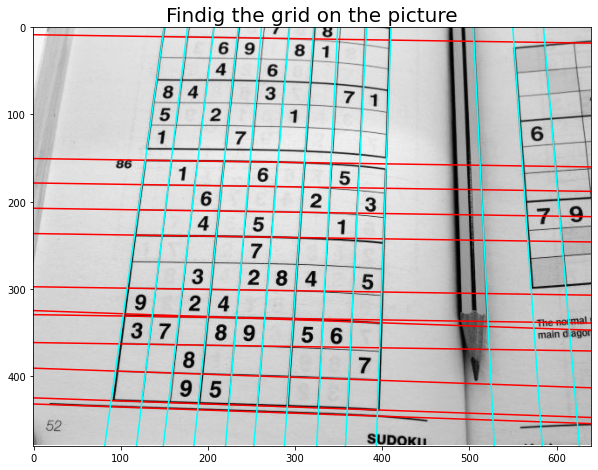

In [24]:
plt.figure(figsize=(10, 12))
for h in lines_horizontal:
    plt.plot(x_size, h, c='red')
for v in lines_vertical:
    plt.plot(x_size, v, c='cyan') 
plt.imshow(gray_image, cmap='gray')
plt.title('Findig the grid on the picture', fontsize=FS)
plt.ylim(img.shape[0], 0)
plt.show()

In [38]:
crossing_points = find_crossing_points(params)
print(f'{crossing_points.shape[0]} crossing point found.')

157 crossing point found.


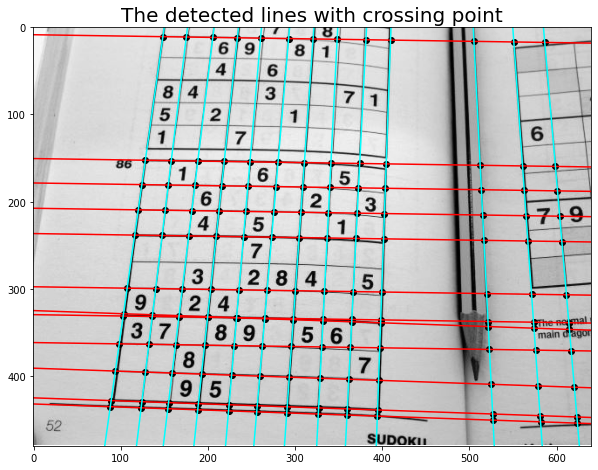

In [27]:
plt.figure(figsize=(10, 12))

for h in lines_horizontal:
    plt.plot(x_size, h, c='red')
for v in lines_vertical:
    plt.plot(x_size, v, c='cyan') 
    
for i in range(len(crossing_points[:,0])):
    plt.scatter(crossing_points[i,0], crossing_points[i,1], c='k')  
    
plt.imshow(gray_image, cmap='gray')
plt.title('The detected lines with crossing point', fontsize=FS)
plt.ylim(img.shape[0], 0)
plt.show()

### Filtering the detected lines.

In [14]:
# filtering horizontal lines
# With the distances of the y axis intersect point we can select the possible sudoku grid lines, due to the equal distances.
rounded_diffs_hor = np.round(np.diff(params_horizontal[:,1]), -1)

# The most common distance will be the 
most_common_diff_hor = Counter(rounded_diffs_hor).most_common(1)[0][0]

# Some grid line does not detected. But the distance must remain the same with a multiple factor.
horizontal_idx_filter = np.logical_and(rounded_diffs_hor >= most_common_diff_hor, rounded_diffs_hor <= most_common_diff_hor*2.5 )
# Append a True to the second position, due to the lenght loss of differentation.
horizontal_idx_filter = np.concatenate((horizontal_idx_filter[:2], [True], horizontal_idx_filter[2:]))
# Generate line for the plots.
lines_horizontal_filt = generate_line(params_horizontal[horizontal_idx_filter])

In [15]:
# filtering vertical lines by slope
# These lines are not paralel due to the angle of the photo. But the greater number of the direction (which is the slope) gives us the possible grid lines.
vertical_idx_filter = params_vertical[:,0]<0
if np.sum(params_vertical[:,0]<0) < len(vertical_idx_filter):
    lines_vertical_filt = generate_line(params_vertical[vertical_idx_filter])
else:
    lines_vertical_filt = generate_line(params_vertical[np.logical_not(vertical_idx_filter)])

### Filtering the crossing points

In [39]:
filt_crossing_points = find_crossing_points(filt_params)
print(f'{filt_crossing_points.shape[0]} crossing point found.')

90 crossing point found.


(480.0, 0.0)

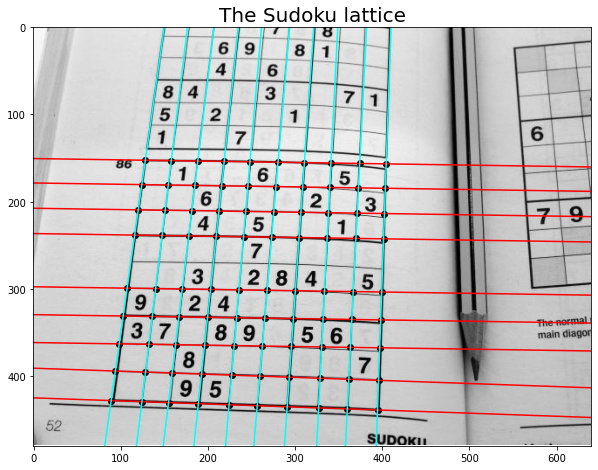

In [40]:
plt.figure(figsize=(10, 12))

# horizontal lines
for h in lines_horizontal_filt:
    plt.plot(x_size, h, c='red')
# vertical lines
for v in lines_vertical_filt:
    plt.plot(x_size, v, c='cyan') 
# crossing points
for i in range(len(filt_crossing_points[:,0])):
    plt.scatter(filt_crossing_points[i,0], filt_crossing_points[i,1], c='k')  
    
# the original grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title('The Sudoku lattice', fontsize=FS)
plt.ylim(img.shape[0], 0)
plt.show()

### Detect the corners of the Sudoku Lattice 

In [19]:
# distance from origin gives us two corner
distances = np.sqrt(filt_crossing_points[:,0]**2 +  filt_crossing_points[:,1]**2 )
corner_1 = filt_crossing_points[distances.argmin()]
corner_4 = filt_crossing_points[distances.argmax()]

# Lowest and highest angle for corner_2 and corner_3
angles = np.arccos(filt_crossing_points[:,0]/distances)
corner_2 = filt_crossing_points[angles.argmax()]
corner_3 = filt_crossing_points[angles.argmin()]

corners = np.array([corner_1, corner_2, corner_3, corner_4])

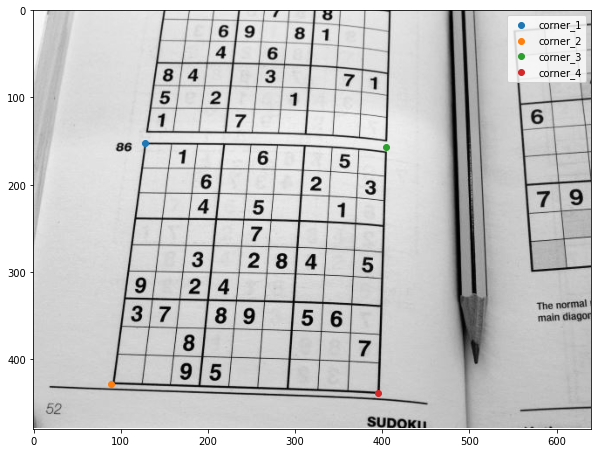

In [20]:
plt.figure(figsize=(10, 12))
plt.imshow(gray_image, cmap='gray')

plt.ylim(0, img.shape[0])
plt.gca().invert_yaxis()

for i, c in enumerate(corners):
    plt.scatter(c[0], c[1], label=f'corner_{i+1}')
plt.legend()    
plt.show()

# Perspective Transformed Image

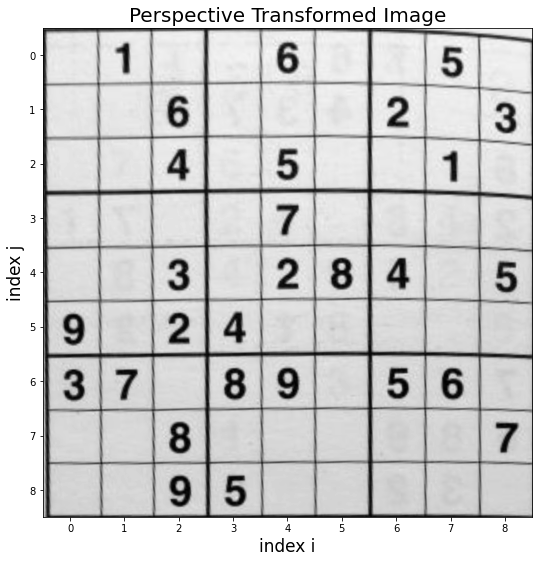

In [44]:
k, N = 9, 100 # size of the transformed picture 
pts1 = np.float32(corners)
pts2 = np.float32([[0,0], [0, k*N], [k*N, 0], [k*N, k*N]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)

transformed_img = np.copy(gray_image)

result = cv2.warpPerspective(transformed_img, matrix, (k*N, k*N))
plt.figure(figsize=(k, k))
plt.imshow(result, cmap='gray')
plt.title('Perspective Transformed Image', fontsize=FS)
plt.xlabel('index i', fontsize=FS-3)
plt.ylabel('index j', fontsize=FS-3)
plt.xticks(np.linspace(0, (k-1)*N, k)+N/2, np.linspace(0, k-1, k, dtype=int))
plt.yticks(np.linspace(0, (k-1)*N, k)+N/2, np.linspace(0, k-1, k, dtype=int))
plt.show() 

### Show any square of the Sudoku grid

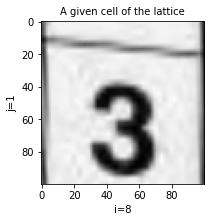

In [52]:
i, j = 8,1

plt.figure(figsize=(k/3, k/3))
plt.imshow(result[N*j:N*(j+1), N*i:N*(i+1)], cmap='gray')
plt.title('A given cell of the lattice', fontsize=FS/2)
plt.xlabel(f'i={i}')
plt.ylabel(f'j={j}')
plt.show()

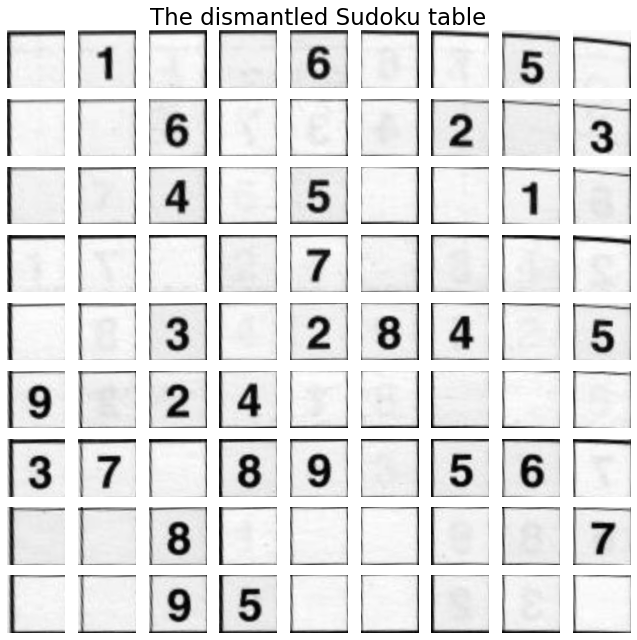

In [65]:
fig, axes = plt.subplots(9, 9, figsize=(9,9))  # --> sudoku grid



for i in range(0,9):
    for j in range(0,9):
        axes[j,i].imshow(result[N*j:N*(j+1), N*i:N*(i+1)], cmap='gray')
        axes[j,i].axis('off')
axes[0,4].set_title('The dismantled Sudoku table', fontsize=FS+3)
plt.tight_layout()
plt.show()

### Recognize numbers
Possible algorythm to recognize the numbers:
- Cross correlation, if all the possible number has a 
- Convolutional neural network (a lot of data needed)

---
The following Stack Overflow link gave me a lot of help to solve this problem: [Find sudoku grid using OpenCV and Python](https://stackoverflow.com/questions/48954246/find-sudoku-grid-using-opencv-and-python).